**1. Load and Preprocess Audio Files**

In [8]:
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def normalize_features(features):
    mean = np.mean(features, axis=0)
    std = np.std(features, axis=0)
    return (features - mean) / std

# Load and preprocess audio files
def load_audio_file(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    return np.mean(mfccs.T, axis=0)

# Paths to audio files
audio_files = ['/content/194720__pfranzen__guy-choking.mp3', '/content/317440__drkvixn91__male-choking_2.wav',
               '/content/52277__rettalo__choking.wav']
features = np.array([load_audio_file(file) for file in audio_files])


**2. Data Augmentation**

In [6]:
def augment_audio(audio, sr):
    # Adding white noise
    noise = np.random.randn(len(audio))
    audio_noise = audio + 0.005 * noise

    # Shifting the time
    audio_shift = np.roll(audio, 1600)

    # Changing the pitch
    audio_pitch = librosa.effects.pitch_shift(audio, sr=sr, n_steps=4)

    return [audio_noise, audio_shift, audio_pitch]

augmented_features = []
for file in audio_files:
    audio, sr = librosa.load(file, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    augmented_features.append(np.mean(mfccs.T, axis=0))

    for aug_audio in augment_audio(audio, sr):
        aug_mfccs = librosa.feature.mfcc(y=aug_audio, sr=sr, n_mfcc=13)
        augmented_features.append(np.mean(aug_mfccs.T, axis=0))

features = np.array(augmented_features)
features = normalize_features(features)

**3. Audio Encoder Model Training**

In [12]:
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

**(i). Convolutional Autoencoder (CAE)**

In [30]:
input_dim = features.shape[1]
model_cae = Sequential([
    Input(shape=(input_dim, 1)),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(input_dim, activation='sigmoid')
])
model_cae.compile(optimizer='adam', loss='mse')
features_cnn = features.reshape(-1, input_dim, 1)
history_cae = model_cae.fit(features_cnn, features_cnn, epochs=100, batch_size=4, validation_split=0.2, callbacks=[early_stopping])



Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 1.4343 - val_loss: 0.8949
Epoch 2/100
1/1 [==============================] - 0s 41ms/step - loss: 1.4132 - val_loss: 0.9007
Epoch 3/100
1/1 [==============================] - 0s 52ms/step - loss: 1.3975 - val_loss: 0.9071
Epoch 4/100
1/1 [==============================] - 0s 40ms/step - loss: 1.3914 - val_loss: 0.9129
Epoch 5/100
1/1 [==============================] - 0s 39ms/step - loss: 1.3584 - val_loss: 0.9194
Epoch 6/100
1/1 [==============================] - 0s 40ms/step - loss: 1.3555 - val_loss: 0.9268
Epoch 7/100
1/1 [==============================] - 0s 38ms/step - loss: 1.3205 - val_loss: 0.9351
Epoch 8/100
1/1 [==============================] - 0s 39ms/step - loss: 1.3027 - val_loss: 0.9441
Epoch 9/100
1/1 [==============================] - 0s 42ms/step - loss: 1.3152 - val_loss: 0.9534
Epoch 10/100
1/1 [==============================] - 0s 37ms/step - loss: 1.2861 - val_loss: 0.9641
Epoch 11/100
1/1 [===

1/1 [==============================] - 0s 102ms/step
Convolutional Autoencoder Evaluation Metrics:
MSE: 1.1369115114212036
RMSE: 1.066260576248169
MAE: 0.8557542562484741


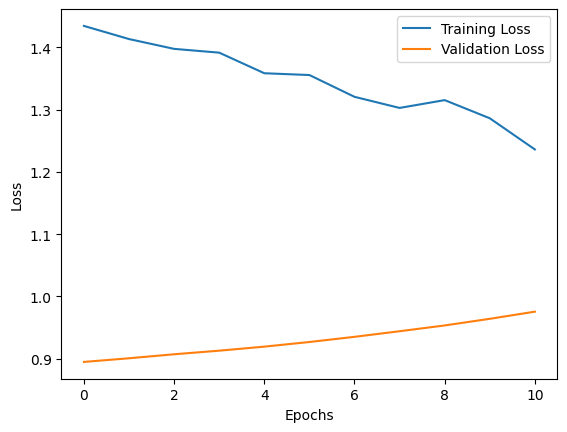

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Evaluate the Convolutional Autoencoder
features_cnn = features.reshape(-1, input_dim, 1)
reconstructed_cnn = model_cae.predict(features_cnn)

# Calculate evaluation metrics
mse_cnn = mean_squared_error(features_cnn.flatten(), reconstructed_cnn.flatten())
rmse_cnn = np.sqrt(mse_cnn)
mae_cnn = mean_absolute_error(features_cnn.flatten(), reconstructed_cnn.flatten())

# Print and visualize evaluation metrics
print("Convolutional Autoencoder Evaluation Metrics:")
print(f"MSE: {mse_cnn}")
print(f"RMSE: {rmse_cnn}")
print(f"MAE: {mae_cnn}")

# Plot training and validation loss from history
plt.plot(history_cae.history['loss'], label='Training Loss')
plt.plot(history_cae.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**(ii) Recurrent Neural Network (RNN) Autoencoder**

In [25]:
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed

# Define the RNN Autoencoder model
model_rnn = Sequential([
    Input(shape=(input_dim, 1)),
    LSTM(64, return_sequences=True),
    LSTM(128, return_sequences=False),
    RepeatVector(input_dim),
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=True),
    TimeDistributed(Dense(1))
])

# Compile the model and train it
model_rnn.compile(optimizer='adam', loss='mse')
features_rnn = features.reshape(-1, input_dim, 1)
history_rnn = model_rnn.fit(features_rnn, features_rnn, epochs=100, batch_size=4, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 1.0344 - val_loss: 0.9515
Epoch 2/100
1/1 [==============================] - 0s 84ms/step - loss: 0.9395 - val_loss: 0.9346
Epoch 3/100
1/1 [==============================] - 0s 84ms/step - loss: 0.8465 - val_loss: 0.9146
Epoch 4/100
1/1 [==============================] - 0s 72ms/step - loss: 0.7418 - val_loss: 0.8894
Epoch 5/100
1/1 [==============================] - 0s 72ms/step - loss: 0.6261 - val_loss: 0.8549
Epoch 6/100
1/1 [==============================] - 0s 70ms/step - loss: 0.5310 - val_loss: 0.8030
Epoch 7/100
1/1 [==============================] - 0s 66ms/step - loss: 0.5352 - val_loss: 0.7690
Epoch 8/100
1/1 [==============================] - 0s 69ms/step - loss: 0.5675 - val_loss: 0.7593
Epoch 9/100
1/1 [==============================] - 0s 69ms/step - loss: 0.5228 - val_loss: 0.7569
Epoch 10/100
1/1 [==============================] - 0s 76ms/step - loss: 0.4703 - val_loss: 0.7559
Epoch 11/100
1/1 [=

1/1 [==============================] - 5s 5s/step
RNN Autoencoder Evaluation Metrics:
MSE: 0.5602360963821411
RMSE: 0.7484892010688782
MAE: 0.5785683989524841


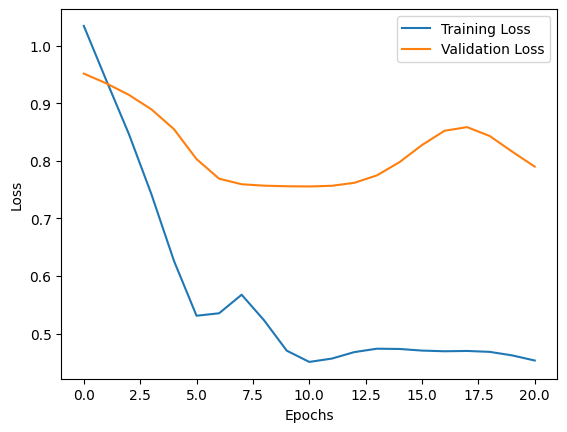

In [32]:
# Evaluate the RNN Autoencoder
features_rnn = features.reshape(-1, input_dim, 1)
reconstructed_rnn = model_rnn.predict(features_rnn)

# Calculate evaluation metrics
mse_rnn = mean_squared_error(features_rnn.flatten(), reconstructed_rnn.flatten())
rmse_rnn = np.sqrt(mse_rnn)
mae_rnn = mean_absolute_error(features_rnn.flatten(), reconstructed_rnn.flatten())

# Print and visualize evaluation metrics
print("RNN Autoencoder Evaluation Metrics:")
print(f"MSE: {mse_rnn}")
print(f"RMSE: {rmse_rnn}")
print(f"MAE: {mae_rnn}")

# Plot training and validation loss from history
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


We can observe that the RNN Autoencoder generally performs better in terms of MSE, RMSE, and MAE compared to the Convolutional Autoencoder. Here's a breakdown of the comparison:

- The RNN Autoencoder has a lower MSE of 0.560, indicating better reconstruction performance compared to the CAE's MSE of 1.137.
RMSE:

- The RNN Autoencoder also has a lower RMSE of 0.748, indicating a smaller average magnitude of error compared to the CAE's RMSE of 1.066.
MAE:

- The RNN Autoencoder's MAE of 0.579 is lower than the CAE's MAE of 0.856, showing that, on average, the RNN Autoencoder's predictions are closer to the actual values.

Based on these metrics, the RNN Autoencoder appears to provide better reconstruction performance than the Convolutional Autoencoder